# Urban Network Analysis
## 12. Trip Assignment – Frank-Wolfe Algorithm

## Introduction

Frank-Wolfe (FW) method proposed by Frank and Wolfe in 1956 is a precedure to solve iterative first-order optimization problem with linear constraint and is known also as the convex combination algorithm [[1]](#Reference). The successive iterations solve a linearized objective function by first order Taylor approximation and find the solution that is an optimal linear combination of the current solution and the auxiliary LP solution.

This method has been applied to traffic assignment problem because of the fact that constraints of traffic assignment problem are linear and the direction finding step can be executed relatively efficiently, All-or-Nothing (AoN) assignment [[2]](#Reference).[[3]](#Reference). This is possible when presuming constant value for link travel time (cost), which solution is to use a single path, the shortest path.

This algorithm has been widely applied to traffic assignment due to simple calculation, using only linear optimization. However, one should keep in mind that the following issues exist [[2]](#Reference):
- FW could have poor convergence after a few iterations
- FW does not have a way to drop bad path, a path whose free flow time is worse than the equilibrium travel time. Such a path may come in from AoN in some iteration but may never leave the path set. This contributes to the equilibrium link flow though its effect keeps reduced at slower rate through iterations.


The link performance ($t(x)$) function in this example is the conventional BPR function developed by the Bureau of Public Roads (BPR, now the U.S. Federal Highway Administration (FHWA)) [[4]](#Reference) . <br/><br/>
$$t(x) = t_0\Big[ 1+\alpha \big( \displaystyle \frac{x}{c} \big)^\beta \Big]$$ <br/>

BPR function is a link cost function which conventionally adopted in static traffic assignment because it is a convex function which essential in minimization process in the user equilibrium model. Strictly speaking, it cannot fully reflect all the traffic condition in reality. As shown in the figures below, BPR function is essentially convex monotonically increasing function, but in reality, we can observed a 'backward-bonding' trend in the roadway segments where congested conditions exit. If your dataset shows the non-convex trend, a remedy will be to use aggregated data over a longer time interval (say, an hour). Regardless of the time interval, applying a dynamic traffic assignment method is also another solution [[2]](#Reference). 

<table>
    <tr>
        <td><img src="Image/BPRLimitation.png" alt="BPR function and link travel time-flow graph" style="width: 700px;"/></td>
    </tr>
    <tr>
        <td>reprinted from He, X., Liu, H., & Peeta, S. (2015). Trafﬁc Network Modeling. In Routledge Handbook of Transportation (pp. 53-69). Routledge [[5]](#Reference).</td>
    </tr>
</table>

Consider a network of SiouxFalls, which widely used in many transportation publications. The network is available from Transportation Networks (https://github.com/bstabler/TransportationNetworks) [[6]](#Reference).
<br/>

<table>
<tr>
<td><img src="Data/TransportationNetworks/SiouxFalls/SiouxFallsMap_AAA1998.jpg" alt="SiouxFalls_network" style="width: 350px;"/></td><td><img src="Data/TransportationNetworks/SiouxFalls/SiouxFalls_network.PNG" alt="SiouxFalls_network" style="width: 350px;"/></td>
</tr>
</table>

## Prerequisites

### 1. Packages and Modules Imported

> ***networkx***

<ul><ul>: For the creation, manipulation, and study of the structure, dynamics, and functions of complex networks
</ul></ul>

> ***scipy.integrate***

<ul><ul>: Provides several integration techniques
</ul></ul>

> ***scipy.optimize***

<ul><ul>: Provides several commonly used optimization algorithms
</ul></ul>

> ***matplotlib.pyplot***

<ul><ul>: Provides a MATLAB-like plotting framework
</ul></ul>

> ***pytrans.UrbanNetworkAnalysis.TransportationNetworks***

<ul><ul>: Module for importing and handling Transportation Networks datasets
</ul></ul>


In [1]:
import networkx as nx
import scipy.integrate as integrate 
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

from pytrans.UrbanNetworkAnalysis import TransportationNetworks as tn

### 2. Functions Defined

> ***BPR***(_t0, xa, ca, alpha, beta_)

<ul><ul>
        : Method for calculating link travel time based on BPR function.<br><br>
        <u> Parameters </u> :
        <ul><ul><br>
                <li>**t0** _(float)_ - free flow travel time on link a. </li>
                <li>**xa** _(float)_ - volume of traffic on line. </li>
                <li>**ca** _(float)_ - capacity of link a. </li>
                <li>**alpha** _(float)_ - alpha coefficient, usually 0.15 in the BPR curve.</li>
                <li>**beta** _(float)_ - beta coefficient, usually 4 in the BPR curve.</li>
        </ul></ul><br>
        <u> Returns </u> :
        <ul><ul><br>
                <li>**ta **_(float)_ - travel time for a vehicle on link a.</li>
        </ul></ul>

In [2]:
def BPR(t0, xa, ca, alpha, beta):
    ta = t0*(1+alpha*(xa/ca)**beta)
    return ta

> ***calculateZ***(_theta, network, SO_)

<ul><ul>
        : Method for calculating objective function value. <br><br>
        <u> Parameters </u> :
        <ul><ul><br>
                <li>**theta** _(float)_ - step size which determies how far along the auxility flow the next flow will be.</li>
                <li>**network** _(dictionary)_ - graph of the current network. </li>
                <li>**SO** _(string)_ - True: if the objective is to find system optimum, False: User equilibrium </li>
        </ul></ul><br>
        <u> Returns </u> :
        <ul><ul><br>
                <li>**z** _(float)_ - estimated objective</li>

In [3]:
def calculateZ(theta, network, SO):
    z = 0
    for linkKey, linkVal in network.items():
        t0 = linkVal['t0']
        ca = linkVal['capa']
        beta = linkVal['beta']
        alpha = linkVal['alpha']
        aux = linkVal['auxiliary'][-1]
        flow = linkVal['flow'][-1]
        
        if SO == False:
            z += integrate.quad(lambda x: BPR(t0, x, ca, alpha, beta), 0, flow+theta*(aux-flow))[0]
        elif SO == True:
            z += list(map(lambda x : x * BPR(t0, x, ca, alpha, beta), [flow+theta*(aux-flow)]))[0]
    return z

> ***lineSearch***(_network, SO_)

<ul><ul>
        : Finds theta, the optimal solution of the line search that minimizing the objective function along the line between current flow and auxiliary flow.<br><br>
        <u> Parameters </u> :
        <ul><ul><br>
                <li>**network** _(dictionary)_ - graph of the current network. </li>
                <li>**SO** _(string)_ - True: if the objective is to find system optimum, False: User equilibrium </li>
        </ul></ul><br>
        <u> Returns </u> :
        <ul><ul><br>
                <li>**theta.x** _(float)_ - optimal move size</li>

In [4]:
def lineSearch(network, SO):
    theta = minimize_scalar(lambda x: calculateZ(x, network, SO), bounds = (0,1), method = 'Bounded')
    return theta.x

## Solution

### Major Variables

#### network _(dictionary)
- t0 (float) : cost at the free flow speed
- capa (float) : capacity of the link
- alpha (float) : alpha coefficient of the BPR funtion, usually 0.15
- beta (float) : the exponent of power of the BPR function, usually 4
- cost (list) : unit cost of the link at the condition of each iteration
- auxiliary (list) : the auxiliary flow of F-W algorithm at the condition of each iteration
- flow (list) : the assigned flow at the condition of each iteration

#### fwResult _(dictionary)
- theta (list) : step size at each iteration
- z (list) : total value of the objective function

### File Paths

In [5]:
directory = ".\\Data\\TransportationNetworks\\SiouxFalls\\"
link_file = '{}SiouxFalls_net.tntp'.format(directory)
trip_file = '{}SiouxFalls_trips.tntp'.format(directory)
node_file = '{}SiouxFalls_node.tntp'.format(directory)

### Set objective and Open a network

In [6]:
SO = False # True - System optimum, False - User equilibrium
siouxFalls = tn.Network(link_file, trip_file, node_file, SO)

### Implement iterative optimization steps (UE)

<h3 align="left"> 1. Initialization </h3><br>
Perform the All-or-Nothing (AoN) assignment based on the free flow travel time (t0) and calculate the link performance (t1) based on the link volume (x0)

In [7]:
## initialization

# define output variables, network and fwResult
network = {(u,v): {'t0':d['object'].t0, 'alpha':d['object'].alpha, \
           'beta':d['object'].beta, 'capa':d['object'].capacity, 'flow':[], \
           'auxiliary':[], 'cost':[]} for (u, v, d) in siouxFalls.graph.edges(data=True)}

fwResult = {'theta':[], 'z':[]}

# initial all-or-nothing assignment and update link travel time(cost)
siouxFalls.all_or_nothing_assignment()
siouxFalls.update_linkcost()

for linkKey, linkVal in network.items():
    linkVal['cost'].append(siouxFalls.graph[linkKey[0]][linkKey[1]]['weight'])
    linkVal['auxiliary'].append(siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].vol)
    linkVal['flow'].append(siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].vol)

<h3 align="left"> 2. Network Loading (Direction Finding) </h3><br>
Perform the AoN assignment based on the link performance (t) to yeild auxiliary link flows (f)

<h3 align="left"> 3. Convex Combination (Step Size Determination) </h3><br>
Set $ x^{n}_{a} = x^{n-1}_a+\theta*(f^{n}_a-x^{n-1}_{a})$ and find $\theta$ that satisfies $Z(x^{n})$, where Z is the objective function e.g. the user equilibrium:

$$min \sum_{a} \int_{0}^{x^{n-1}_a+\theta(f^{n}_a-x^{n-1}_{a})} t_{a}(\omega) d\omega$$
$$ s.t. \hspace{0.5cm} 0\leq\theta\leq1 $$
<br/>
Solve)<br/>
let:<br/> 
$$F(\theta) = \sum_{a} \int_{0}^{x^{n-1}_a+\theta(f^{n}_a-x^{n-1}_{a})} t_{a}(\omega) d\omega$$ 

then:<br/>
$$F^{(1)}(\theta) = \sum_{a}(f^{n}_a-x^{n-1}_{a})*t_{a}\big(x^{n-1}_a+\theta(f^{n}_a-x^{n-1}_{a})\big)$$

find $\theta$ that satisfies  <br/>
$$F^{(1)}(\theta) = 0$$

<h3 align="left"> 4. Move and Update </h3><br>
Calculate the current flow $x^{n}_{a}$ based on the $\theta$ obtained and set $t^{n+1}_{a} = t_{a}(x^{n}_{a})$

<h3 align="left"> 5. Convergence Test </h3><br>
If the convergence criteron is met, stop. Otherwise, increase iteration number and go to the step 3.1). This example has a convergence criterion: 
<br/>

$$| Z(x^{n}) - Z(x^{n-1}) | < 0.001$$

In [8]:
## iterations
iterNum=0
iteration = True
while iteration:
    iterNum += 1
    siouxFalls.all_or_nothing_assignment()
    siouxFalls.update_linkcost()
    
    # set auxiliary flow using updated link flow
    for linkKey, linkVal in network.items():
        linkVal['auxiliary'].append(siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].vol)
        
    # getting optimal move size (theta)
    theta = lineSearch(network, SO)
    fwResult['theta'].append(theta)
    
    # set link flow (move) based on the theta, auxiliary flow, and link flow of previous iteration
    for linkKey, linkVal in network.items():
        aux = linkVal['auxiliary'][-1]
        flow = linkVal['flow'][-1]
        linkVal['flow'].append(flow + theta*(aux-flow))
        
        siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].vol =  flow + theta * (aux - flow)
        siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].flow = flow + theta * (aux - flow)
        
    # update link travel time
    siouxFalls.update_linkcost()
    
    # calculate objective function value
    z=0
    for linkKey, linkVal in network.items():
        linkVal['cost'].append(siouxFalls.graph[linkKey[0]][linkKey[1]]['weight'])
        totalcost = siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].get_objective_function()
        z+=totalcost
        
    fwResult['z'].append(z)        
        
    # convergence test
    if iterNum == 1:
        iteration = True
    else:
        if abs(fwResult['z'][-2] - fwResult['z'][-1]) <= 0.001 or iterNum==3000:
            iteration = False

## Results

### 1.Link Flow

In [9]:
for (u, v, d) in siouxFalls.graph.edges(data=True):
    print(u, ' -> ', v, ': ', d['object'].vol)

1  ->  2 :  4494.54176989006
1  ->  3 :  8118.778958272509
2  ->  1 :  4519.221797914771
2  ->  6 :  5967.415424211337
3  ->  1 :  8094.09893024779
3  ->  4 :  14011.734532508233
3  ->  12 :  10027.635980548692
6  ->  2 :  5992.095452236077
6  ->  5 :  8806.410890352707
6  ->  8 :  12492.07533900986
4  ->  3 :  14035.300255005786
4  ->  5 :  18010.561177812673
4  ->  11 :  5203.138655250309
12  ->  3 :  9979.390230026394
12  ->  11 :  8404.30673577725
12  ->  13 :  12293.499582238235
5  ->  4 :  18034.525517790804
5  ->  6 :  8797.189586936702
5  ->  9 :  15783.996289374203
11  ->  4 :  5302.740037769658
11  ->  10 :  17603.652145820124
11  ->  12 :  8365.25930429379
11  ->  14 :  9776.84654329423
9  ->  5 :  15798.73932593642
9  ->  8 :  6837.003588189477
9  ->  10 :  21745.988235038363
8  ->  6 :  12525.976670450578
8  ->  7 :  12041.696631494666
8  ->  9 :  6881.813917125096
8  ->  16 :  8387.782258652309
7  ->  8 :  12102.268632504787
7  ->  18 :  15797.411851114739
18  ->  7 :  15

### 2. Visualization

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:861: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


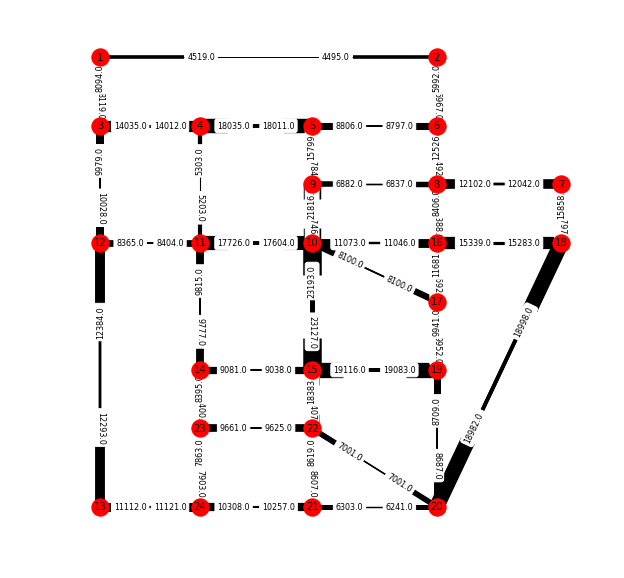

In [10]:
edgewidth = [d['object'].vol/5000 for (u, v, d) in siouxFalls.graph.edges(data=True)]

if node_file != None:
    plt.figure(num = 1, figsize=(10,10))
    plt.axis('off')
    
    pos = nx.get_node_attributes(siouxFalls.graph, "pos")

    nx.draw_networkx_edges(siouxFalls.graph, pos, width=edgewidth)
    nx.draw_networkx_edge_labels(siouxFalls.graph, pos, \
                                 edge_labels={(u, v): round(d["object"].vol,0) for u, v, d in siouxFalls.graph.edges(data=True)}, \
                                 font_size=8, label_pos=0.3, alpha=0.)
    nx.draw_networkx_nodes(siouxFalls.graph, pos, with_labels=True)
    nx.draw_networkx_labels(siouxFalls.graph, pos, font_size=10)
    
    plt.show()

## Reference

[1] Frank, M., & Wolfe, P. (1956). An algorithm for quadratic programming. Naval Research Logistics (NRL), 3(1‐2), 95-110.<br/>
[2] Jayakrishnan, R. (2017). CEE228B: Transportation Networks II, lecture notes.<br/>
__[[3]](http://web.mit.edu/sheffi/www/selectedMedia/sheffi_urban_trans_networks.pdf)__ Sheffi, Y. (1985). Urban transportation networks.<br/>
__[[4]](https://en.wikibooks.org/wiki/Fundamentals_of_Transportation/Route_Choice)__ Fundamentals of Transportation/Route Choice. (n.d.). Retrieved November 30, 2017, from h<span>ttps://en.wikibooks.org/wiki/Fundamentals_of_Transportation/Route_Choice <br/>
__[[5]](https://www.routledgehandbooks.com/doi/10.4324/9781315756684.ch3)__ He, X., Liu, H., & Peeta, S. (2015). Trafﬁc Network Modeling. In Routledge Handbook of Transportation (pp. 53-69). Routledge.
[6] Transportation Networks for Research Core Team. Transportation Networks for Research. https://github.com/bstabler/TransportationNetworks. Accessed Feb, 10, 2018.<br/>
